In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
#read saved csv file
conComplaintDf=pd.read_csv("Consumer_Complaints.csv",converters={'ZIP code': lambda x: str(x)})

#ccDf=conComplaintDf.groupby(['Company response to consumer']).count()


In [2]:
#order the responses
#0 closed with monetary relief
#1 closed with non-monetary relief
#2 closed with relief
#3 closed with explanation
#4 closed
#5 closed without relief
#6 untimely response
#7 in progress
conComplaintDf['respCode']=np.where(conComplaintDf['Company response to consumer']== 'Closed with monetary relief',0,
    np.where(conComplaintDf['Company response to consumer']== 'Closed with non-monetary relief',1,
        np.where(conComplaintDf['Company response to consumer']== 'Closed with relief',2,
            np.where(conComplaintDf['Company response to consumer']== 'Closed with explanation',3,
                np.where(conComplaintDf['Company response to consumer']== 'Closed',4,
                    np.where(conComplaintDf['Company response to consumer']== 'Closed without relief',5,
                        np.where(conComplaintDf['Company response to consumer']== 'Untimely response',6,
                            np.where(conComplaintDf['Company response to consumer']== 'In progress',7,8))))))))

In [7]:
#clean the date received field
#convert 'date received' column from string to datetime
#align all complaints to end of month 
#create a month-year column

import calendar
import datetime

#conComplaintDfStg['Date received'].dtype
conComplaintDf['dateRec']=pd.to_datetime(conComplaintDf['Date received'])#,format='%B/%d/%y')
conComplaintDf['adjDate'] = conComplaintDf['dateRec'].map(
    lambda x: datetime.datetime(
        x.year,
        x.month,
        max(calendar.monthcalendar(x.year, x.month)[-1][:5])
    )
)
conComplaintDf['monYear']=conComplaintDf['adjDate'].apply(lambda x: x.strftime('%B-%Y'))


In [11]:
#drop rows without complete information(6&7) create data frames for EDA

#conComplaintDfStg=
conComplaintDf.drop(conComplaintDf[conComplaintDf.respCode >=6].index, inplace=True)


#create dataframe with complaints resulting in monetary relief
response0Df=conComplaintDf.loc[(conComplaintDf.respCode== 0)]
                               

In [5]:
#urban area to cbsa and urban area to zip code file from census site 
#merge files then merge onto consumer complaint data set

#download urban area to zip5 file

import urllib.request
import requests
import io
url="https://www2.census.gov/geo/docs/maps-data/data/rel/ua_zcta_rel_10.txt"
uaToZipDf=pd.read_csv(url,converters={'ZCTA5': lambda x: str(x)})
uaToZipDf=uaToZipDf[['UA','UANAME','ZCTA5']]


In [7]:
#download urban area to cbsa file
#UA:urban area number
#UANAME: urban area name
#CBSA: corebased statistical area number(micro/metropolitan statistical area)
#MNAME: cbsa name
#MEMI: 1=metropolitan statistical area; 2=micropolitan statistical area
url="https://www2.census.gov/geo/docs/maps-data/data/rel/ua_cbsa_rel_10.txt"
uaToCbsaDf=pd.read_csv(url)#converters={'ZCTA5': lambda x: str(x)})
uaToCbsaDf=uaToCbsaDf[['UA','UANAME','CBSA','MNAME','MEMI']]
uaToCbsaDf.drop(uaToCbsaDf[uaToCbsaDf.MEMI != 1 ].index, inplace=True)

#uaToCbsaDf.head(10)

In [8]:
#this part isn't needed
#download zip to cbsa file

import urllib.request
import requests
import io
url="https://www2.census.gov/geo/docs/maps-data/data/rel/zcta_cbsa_rel_10.txt"
#zipToSaDf=pd.read_csv(url,'ZCTA5',index_col=0)
#preserve leading zeros in zip5
zipToSaDf=pd.read_csv(url,converters={'ZCTA5': lambda x: str(x)})
#zipToSaDf.head(10)

#testfile= urllib.request.urlretrieve("https://www2.census.gov/geo/docs/maps-data/data/rel/zcta_cbsa_rel_10.txt","zipToSa.txt")
#zipToSaData= urllib.request.urlopen("https://www2.census.gov/geo/docs/maps-data/data/rel/zcta_cbsa_rel_10.txt")
#zipToSaDf= pd.read_csv(io.StringIO(zipToSaData.decode(utf-8)))
#testfile.retrieve("https://www2.census.gov/geo/docs/maps-data/data/rel/zcta_cbsa_rel_10.txt","zipToSa.txt")


In [9]:
#merge census files and match zip5 to msa data:ua-> zip5 -> ua -> cbsa
cbsa= pd.merge(uaToZipDf,uaToCbsaDf,on='UA',how='outer')
#cbsa.head(100)

In [ ]:
#import gazeteer files for lat/long data
url="http://www2.census.gov/geo/docs/maps-data/data/gazetteer/Gaz_ua.zip"
uaGaz=pd.read_csv(url)#converters={'ZCTA5': lambda x: str(x)})


In [ ]:
#merge cbsa-zip file with complaint data
#conCompStgRnd=conComplaintDfStg.set_index(['ZIP code'])
#conCompStgRnd.sort_index()


#cbsaRnd=cbsa.set_index(['ZCTA5'])
#cbsaRnd.sort_index()
conComplaintMsaDf=pd.merge(conComplaintDf,cbsa,left_on='ZIP code', right_on='ZCTA5',how='inner')
#left_index= True,right_index= True, how='inner')                           #left_on='ZIP code',right_on='ZCTA5',how='left')


In [ ]:
# Look at length of consumer complaint narrative
conComplaintDf['narrLength']=conComplaintDf['Consumer complaint narrative'].str.len()
zipLen=conComplaintDf['ZIP code'].str.len()
zipLen.describe()
#conComplaintDf
#ccDfConCpltNarr=conComplaintDf.groupby(level=['Company response to consumer','Consumer complaint narrative']).len()

In [ ]:
# look at major fields
conComplaintIndDf=conComplaintDf.set_index(['Company response to consumer','State','ZIP code','Product',
    'Sub-product','narrLength'])
ccDfSt=conComplaintIndDf.groupby(level=['Company response to consumer','State']).count()
ccDfZp=conComplaintIndDf.groupby(level=['Company response to consumer','ZIP code']).count()
ccDfProd=conComplaintIndDf.groupby(level=['Company response to consumer','Product']).count()
ccDfSubProd=conComplaintIndDf.groupby(level=['Company response to consumer','Sub-product']).count()
ccDfNarrLength=conComplaintIndDf.groupby(level=['Company response to consumer','narrLength']).count()


In [8]:

import calendar
import datetime
conComplaintDf['adjDate'] = conComplaintDf['dateRec'].map(
    lambda x: datetime.datetime(
        x.year,
        x.month,
        max(calendar.monthcalendar(x.year, x.month)[-1][:5])
    )
)
conComplaintDf['monYear']=conComplaintDf['adjDate'].apply(lambda x: x.strftime('%B-%Y'))


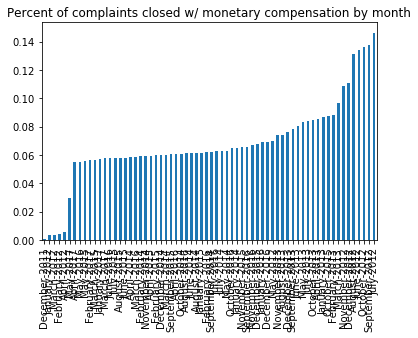

In [17]:

#histograms for month/Year- percent of responses w/monetary compensation of all complaints
monYearAll=conComplaintDf.monYear.value_counts()
monYear0=response0Df.monYear.value_counts()
resp0MonYearPct=monYear0/monYearAll
resp0MonYearPct.sort_values(inplace=True)
#resp0MonYearPct

resp0MonYearPct.plot(kind='bar',title='Percent of complaints closed w/ monetary compensation by month')
plt.xlabel('Month')
plt.ylabel('Percent')
plt.show()



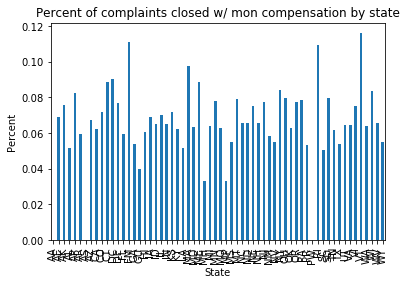

In [23]:
#histograms for state- percent of responses w/monetary compensation of all complaints
stateAll=conComplaintDf.State.value_counts()
state0=response0Df.State.value_counts()
resp0StatePct=state0/stateAll
resp0StatePct.plot(kind='bar',title='Percent of complaints closed w/ monetary compensation by state')
plt.xlabel('State')
plt.ylabel('Percent')
plt.show()


#plot(kind='bar')
#conComplaintDf.'ZIP code'.value_counts().plot(kind='bar')



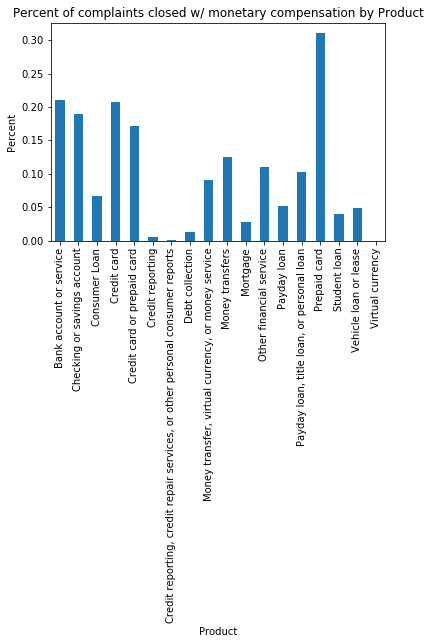

In [36]:
#histograms for Product- percent of responses w/monetary compensation of all complaints
prodAll=conComplaintDf.Product.value_counts()
prod0=response0Df.Product.value_counts()
resp0ProdPct=prod0/prodAll
resp0ProdPct.plot(kind='bar',title='Percent of complaints closed w/ monetary compensation by Product')
plt.xlabel('Product')
plt.ylabel('Percent')
plt.show()




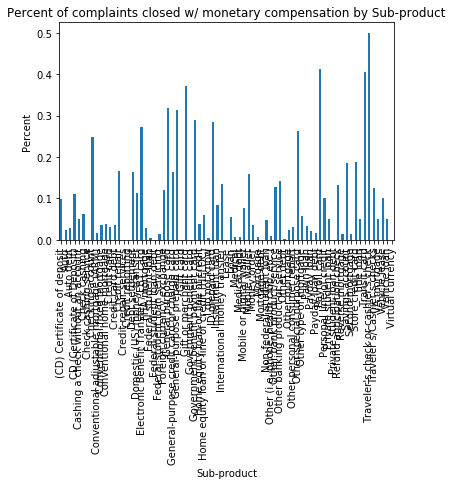

In [35]:
#histograms for product
#histograms for Product- percent of responses w/monetary compensation of all complaints
sProdAll=conComplaintDf['Sub-product'].value_counts()
sProd0=response0Df['Sub-product'].value_counts()
resp0SprodPct=sProd0/sProdAll
resp0SprodPct.plot(kind='bar',title='Percent of complaints closed w/ monetary compensation by Sub-product')
plt.xlabel('Sub-product')
plt.ylabel('Percent')
plt.show()


In [ ]:
#histograms for state with monetary compensation
response0.State.value_counts().plot(kind='bar')
#response0.'ZIP code'.value_counts().plot(kind='bar')


In [ ]:
#histograms for product with monetary compensation

response0.Product.value_counts().plot(kind='bar')
